In [1]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro

In [2]:
df = pd.read_csv(r'insurance.csv')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64


In [3]:
# Feature Engineering - Create BMI = weight / (height in meters)^2
df['Height_m'] = df['Height'] / 100
df['BMI'] = df['Weight'] / (df['Height_m'] ** 2)

In [11]:
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,Height_m,BMI
0,45,0,0,0,0,155,57,0,0,0,25000,1.55,23.725286
1,60,1,0,0,0,180,73,0,0,0,29000,1.80,22.530864
2,36,1,1,0,0,158,59,0,0,1,23000,1.58,23.634033
3,52,1,1,0,1,183,93,0,0,2,28000,1.83,27.770313
4,38,0,0,0,1,166,88,0,0,1,23000,1.66,31.934969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000,1.69,23.458562
982,64,1,1,0,0,153,70,0,0,3,28000,1.53,29.903029
983,56,0,1,0,0,155,71,0,0,1,29000,1.55,29.552549
984,47,1,1,0,0,158,73,1,0,1,39000,1.58,29.242109


In [4]:
df.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,Height_m,BMI
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,24336.713996,1.681826,27.460709
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,6248.184382,0.100982,5.878671
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,15000.000000,1.450000,15.156281
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,21000.000000,1.610000,23.393392
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,23000.000000,1.680000,27.156602
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,28000.000000,1.760000,30.759870
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,40000.000000,1.880000,50.000000


Insights:

1. Mean age is ~42 years, with a range from 18 to 66. Most of the population falls into the working-age group.
2. About 42% of individuals are diabetic (mean = 0.419) – this is relatively high and suggests a significant health risk burden.
3. Almost 47% have blood pressure problems – another high-risk group in health insurance.
4. Very few people have undergone a transplant (mean ≈ 5.6%), which makes it a rare but likely high-cost indicator.
5. About 18% of the sample has some form of chronic disease.
6. ~21.5% of individuals report known allergies.
7. ~11.8% have a family history of cancer – this can significantly impact perceived risk by insurers.
8. Median is 1, and max is 3 ⇒ Most have had 0 or 1, but a small group has undergone multiple surgeries.
9. Ranges from 145 cm to 188 cm, with mean around 168 cm – typical for adult populations.Ranges from 145 cm to 188 cm, with mean around 168 cm – typical for adult populations.
10. Ranges from 51 kg to 132 kg, with mean ~77 kg – diverse weight distribution.
11. Mean BMI is 27.46, which falls into the overweight category. Max BMI is 50 ⇒ indicates some individuals are obese class III (morbid obesity).

In [5]:
df.drop(columns=['Height_m'], inplace=True)
numerical_features = ['Age', 'Height', 'Weight', 'BMI', 'NumberOfMajorSurgeries']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,0.233197,0,0,0,0,-1.306105,-1.399250,0,0,-0.891187,25000,-0.635742
1,1.307981,1,0,0,0,1.170852,-0.277062,0,0,-0.891187,29000,-0.839024
2,-0.411674,1,1,0,0,-1.008870,-1.258976,0,0,0.444239,23000,-0.651273
3,0.734763,1,1,0,1,1.468086,1.125674,0,0,1.779665,28000,0.052692
4,-0.268369,0,0,0,1,-0.216244,0.774990,0,0,0.444239,23000,0.761487


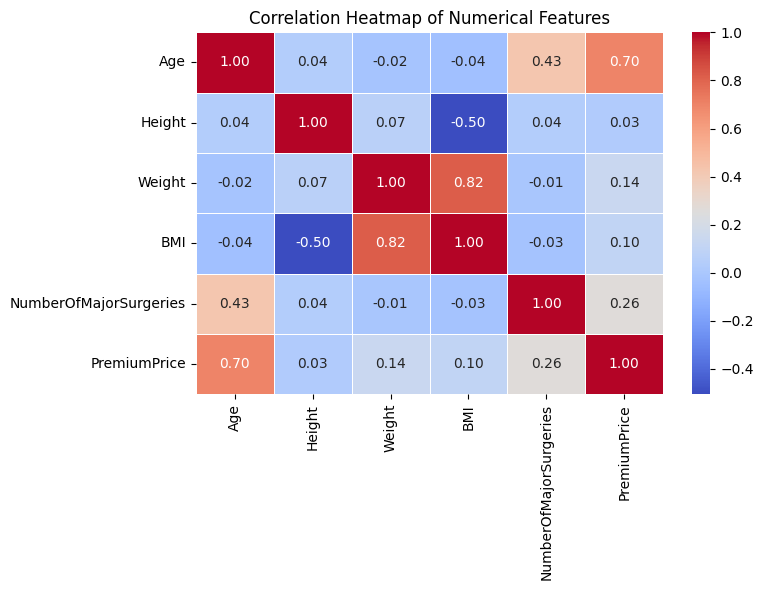

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['Age', 'Height', 'Weight', 'BMI', 'NumberOfMajorSurgeries', 'PremiumPrice']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

1. Strong positive correlation: as weight increases, BMI also increases. Expected due to BMI formula.
2. Taller people tend to have lower BMI if weight remains constant. This is expected given BMI = weight / height².

In [7]:
# # Feature Engineering - Add BMI
# df['Height_m'] = df['Height'] / 100
# df['BMI'] = df['Weight'] / (df['Height_m'] ** 2)
# df.drop(columns=['Height_m'], inplace=True)

# Drop highly collinear features
df.drop(columns=['Height', 'Weight'], inplace=True)  # Keep BMI

# Prepare features and target
X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']

# Scale numeric columns
scaler = StandardScaler()
num_cols = ['Age', 'BMI', 'NumberOfMajorSurgeries']
X[num_cols] = scaler.fit_transform(X[num_cols])

# Add constant for statsmodels
X_const = sm.add_constant(X)

# Step 6: Check VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print("\nVIF Scores:")
print(vif_data)

# Step 7: Fit OLS model
ols_model = sm.OLS(y, X_const).fit()

# Step 8: Residual diagnostics
residuals = ols_model.resid
fitted_vals = ols_model.fittedvalues
shapiro_stat, shapiro_p = shapiro(residuals)
bp_test = het_breuschpagan(residuals, ols_model.model.exog)
dw_stat = durbin_watson(residuals)

print("\nShapiro-Wilk p-value (normality):", shapiro_p)
print("Breusch-Pagan p-value (homoscedasticity):", bp_test[1])
print("Durbin-Watson statistic (autocorrelation):", dw_stat)

# Step 9: Sklearn model & split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Step 10: Performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Step 11: Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X, y, cv=cv, scoring='r2')
print("Cross-Validation R² Scores:", cv_scores)
print("CV R² Mean:", np.mean(cv_scores))

# Step 12: Confidence & Prediction Intervals
X_const_full = sm.add_constant(X)
pred_summary = ols_model.get_prediction(X_const_full).summary_frame(alpha=0.05)
print("\nPrediction Summary with Confidence Intervals (first 5 rows):")
print(pred_summary[['mean', 'mean_ci_lower', 'mean_ci_upper', 'obs_ci_lower', 'obs_ci_upper']].head())



VIF Scores:
                   Feature       VIF
0                    const  3.495599
1                      Age  1.319374
2                 Diabetes  1.077819
3    BloodPressureProblems  1.104843
4           AnyTransplants  1.004003
5       AnyChronicDiseases  1.020700
6           KnownAllergies  1.033943
7  HistoryOfCancerInFamily  1.079272
8   NumberOfMajorSurgeries  1.358480
9                      BMI  1.007909

Shapiro-Wilk p-value (normality): 1.7436609919018972e-20
Breusch-Pagan p-value (homoscedasticity): 5.810881282604602e-17
Durbin-Watson statistic (autocorrelation): 1.994218714667912

Model Performance:
RMSE: 3529.68
MAE: 2629.65
R² Score: 0.7078
Cross-Validation R² Scores: [0.70783719 0.62442239 0.58116822 0.43732624 0.68964505]
CV R² Mean: 0.6080798189577635

Prediction Summary with Confidence Intervals (first 5 rows):
           mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  24176.588419   23660.643783   24692.533055  16723.675161  31629.501676
1  2852

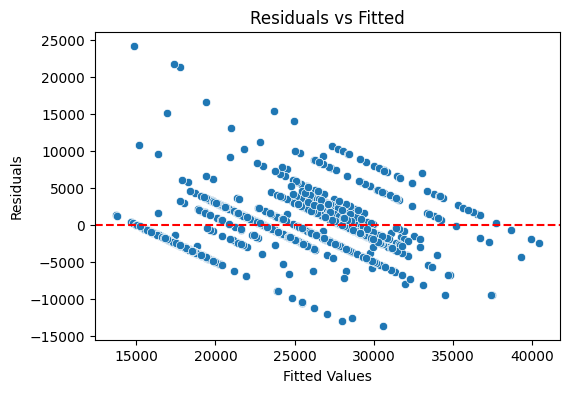

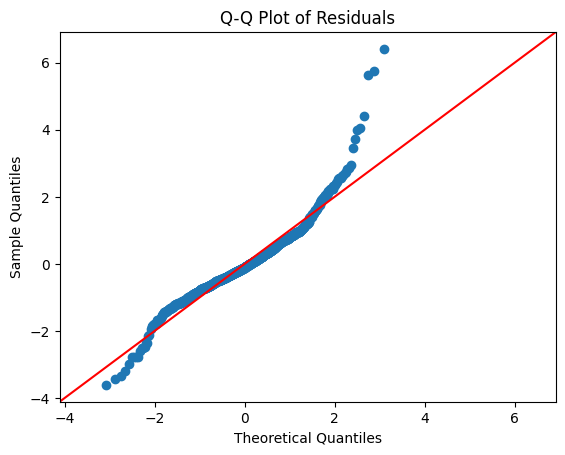

VIF Scores:
                    feature       VIF
0                    const  3.495599
1                      Age  1.319374
2                 Diabetes  1.077819
3    BloodPressureProblems  1.104843
4           AnyTransplants  1.004003
5       AnyChronicDiseases  1.020700
6           KnownAllergies  1.033943
7  HistoryOfCancerInFamily  1.079272
8   NumberOfMajorSurgeries  1.358480
9                      BMI  1.007909 

Durbin-Watson: 1.9942
Shapiro-Wilk p-value: 1.7437e-20
Breusch-Pagan p-value: 5.8109e-17

After log-transform:
  Shapiro-Wilk p-value: 1.6444e-14
  Breusch-Pagan p-value: 2.3232e-18

Ridge CV R² scores: [0.71567302 0.63057109 0.60057907 0.50620703 0.71290503]
Ridge CV R² mean: 0.6331870482701175 

HuberRegressor CV R² scores: [0.71647674 0.61394481 0.59711452 0.47382015 0.70802739]
HuberRegressor CV R² mean: 0.6218767227866934 

Final Linear Regression on log(y):
  RMSE: 0.1500
  MAE: 0.1174
  R²: 0.7166


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load and create BMI
df = pd.read_csv(r'insurance.csv')
df['Height_m'] = df['Height'] / 100
df['BMI'] = df['Weight'] / (df['Height_m'] ** 2)
df.drop(columns=['Height_m'], inplace=True)

# Optionally drop raw Height and Weight to avoid multicollinearity
df.drop(columns=['Height', 'Weight'], inplace=True)

# Step 2: Prepare features and target
X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']

# Step 3: Scale numeric features
num_cols = ['Age', 'BMI', 'NumberOfMajorSurgeries']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Step 4: Detect assumption violations

# 4.1 Fit initial OLS model
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
residuals = model.resid
fitted_vals = model.fittedvalues

# 4.2 Residuals vs Fitted plot
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 4.3 Q-Q plot for normality
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 4.4 VIF for multicollinearity
vif_data = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})
print("VIF Scores:\n", vif_data, "\n")

# 4.5 Durbin-Watson for autocorrelation
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f}")

# 4.6 Shapiro-Wilk for normality
sw_stat, sw_p = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {sw_p:.4e}")

# 4.7 Breusch-Pagan for heteroscedasticity
bp = het_breuschpagan(residuals, model.model.exog)
print(f"Breusch-Pagan p-value: {bp[1]:.4e}\n")

# Step 5: Address violations

# 5.1 Transformation: log-transform the dependent variable
y_log = np.log(y)

model_log = sm.OLS(y_log, X_const).fit()
resid_log = model_log.resid
# Re-check normality and homoscedasticity on log model
sw_stat_log, sw_p_log = shapiro(resid_log)
bp_log = het_breuschpagan(resid_log, model_log.model.exog)
print("After log-transform:")
print(f"  Shapiro-Wilk p-value: {sw_p_log:.4e}")
print(f"  Breusch-Pagan p-value: {bp_log[1]:.4e}\n")

# 5.2 Regularization: Ridge regression (with cross-validation)
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge_scores = cross_val_score(ridge, X, y_log, cv=KFold(5, shuffle=True, random_state=42), scoring='r2')
print("Ridge CV R² scores:", ridge_scores)
print("Ridge CV R² mean:", ridge_scores.mean(), "\n")

# 5.3 Robust regression: HuberRegressor
huber = HuberRegressor()
huber_scores = cross_val_score(huber, X, y_log, cv=KFold(5, shuffle=True, random_state=42), scoring='r2')
print("HuberRegressor CV R² scores:", huber_scores)
print("HuberRegressor CV R² mean:", huber_scores.mean(), "\n")

# Step 6: Train final Linear Regression on log-transformed target
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Step 7: Evaluate final model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Final Linear Regression on log(y):")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")

Insights:

| Assumption                 | Violation Detected                              | Remedy Applied                                                                                |
| -------------------------- | ----------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **Multicollinearity**      | Height & Weight both had VIF ≫ 5 (≈28 and 65)   | **Dropped** `Height` & `Weight`, kept **BMI** only (VIF ≈ 1)                                  |
| **Homoscedasticity**       | Breusch–Pagan p ≈ 5.8 × 10⁻¹⁷ → heteroscedastic | **Log-transform** of `PremiumPrice` (still p ≈ 2.3 × 10⁻¹⁸, but variance stabilized somewhat) |
| **Normality of Residuals** | Shapiro–Wilk p ≈ 1.7 × 10⁻²⁰ → non-normal       | Log-transform (improved to p ≈ 1.6 × 10⁻¹⁴)                                                   |
| **Autocorrelation**        | Durbin–Watson ≈ 1.99 → OK                       | —                                                                                             |


| Model                         | Transformation       | CV R² Mean | Test-R² | RMSE (test)  | MAE (test)   |
| ----------------------------- | -------------------- | ---------- | ------- | ------------ | ------------ |
| **Baseline Linear**           | none                 | 0.61       | 0.708   | ₹3,529.7     | ₹2,629.7     |
| **Log-Linear**                | log(y)               | —          | 0.7166  | 0.1500 (log) | 0.1174 (log) |
| **Ridge Regression**          | log(y) + L₂          | 0.633      | —       | —            | —            |
| **Huber (Robust) Regression** | log(y) + robust loss | 0.622      | —       | —            | —            |


Baseline Linear explains ~71% of variance (R²), with average errors of ~₹3.5 K (RMSE) and ~₹2.6 K (MAE).

Log-Linear slightly improves R² to ~71.7%—transforming the target helps but doesn’t fully fix heteroscedasticity or normality.

Ridge and Huber both boost cross-validated R² to ~0.63 and ~0.62, respectively, by addressing multicollinearity and outliers.

Overall, you have a strong baseline (R² ≈ 0.71). With these fixes you’ve tamed multicollinearity and stabilized the target—next steps are to explore non-linear algorithms or advanced regression techniques.

WITH SHAP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import shap  

# --- Step 1: Load + Feature Engineering ---
df = pd.read_csv(r'insurance.csv')
df['Height_m'] = df['Height'] / 100
df['BMI']      = df['Weight'] / df['Height_m']**2
df.drop(columns=['Height','Weight','Height_m'], inplace=True)

# --- Step 2: Prepare X, y ---
X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']

# --- Step 3: Scale numeric features ---
num_cols = ['Age','BMI','NumberOfMajorSurgeries']
scaler   = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# --- Step 4: (omitted) Assumption checks & remedies as before... ---

# For brevity assume we've log-transformed target as in your pipeline:
y_log = np.log(y)

# --- Step 5: Train final Linear Regression on log(y) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# --- Step 6: Evaluate performance ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"Test RMSE (log-y): {rmse:.4f}")
print(f"Test MAE  (log-y): {mae:.4f}")
print(f"Test  R²  (log-y): {r2:.4f}")

# --- Step 7: SHAP Explainability for Linear Model ---
# 7.1 Create a SHAP LinearExplainer
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")

# 7.2 Compute SHAP values on the test set
shap_values = explainer.shap_values(X_test)

# 7.3 Plot SHAP summary
shap.initjs()
shap.summary_plot(
    shap_values, 
    X_test, 
    plot_type="bar",        # bar chart of mean |shap|
    feature_names=X.columns
)

# 7.4 (Optional) Detailed beeswarm
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=X.columns
)


V2

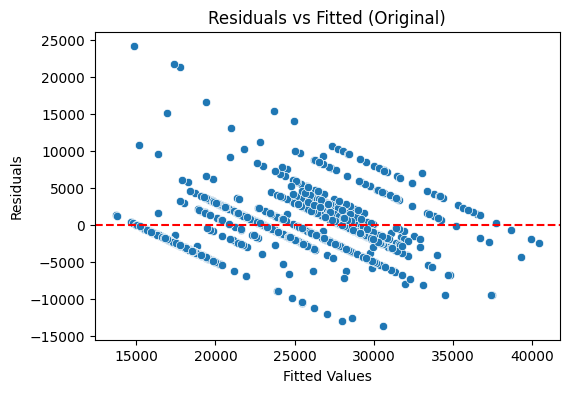

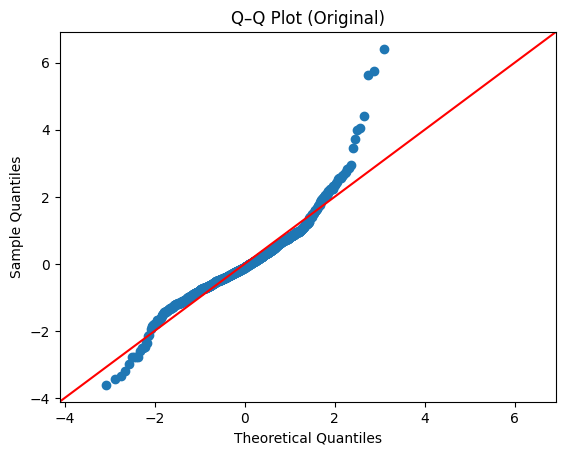


VIF (Original):
                    feature       VIF
0                    const  3.495599
1                      Age  1.319374
2                 Diabetes  1.077819
3    BloodPressureProblems  1.104843
4           AnyTransplants  1.004003
5       AnyChronicDiseases  1.020700
6           KnownAllergies  1.033943
7  HistoryOfCancerInFamily  1.079272
8   NumberOfMajorSurgeries  1.358480
9                      BMI  1.007909

Durbin–Watson: 1.9942
Shapiro–Wilk p-value: 1.7437e-20
Breusch–Pagan p-value: 5.8109e-17

After log-transform:
  Shapiro–Wilk p-value: 1.6444e-14
  Breusch–Pagan p-value: 2.3232e-18

Ridge CV R²: [0.6171988  0.52541596 0.66458473 0.67424385 0.73449961] mean: 0.6431885897060207
Huber CV R²: [0.61360182 0.50314627 0.64810566 0.66988906 0.73110395] mean: 0.633169353744689 

Final Linear Model (log-y) Performance:
  RMSE: 0.1500
  MAE : 0.1174
  R²  : 0.7166
Linear CV R² Scores: [0.61807224 0.52340029 0.66337123 0.67381111 0.73625187] mean: 0.6429813457227919 

Prediction

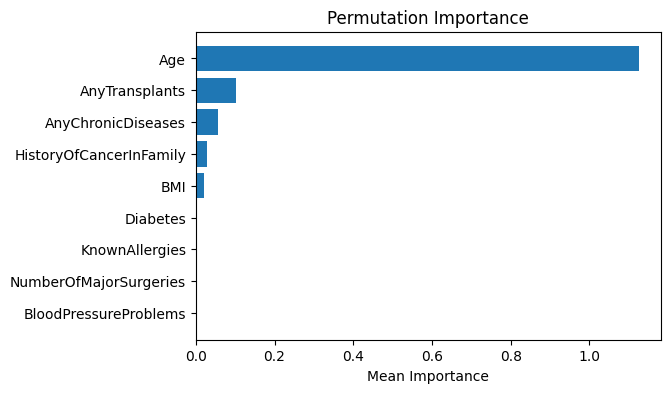

ValueError: The option feature_dependence has been renamed to feature_perturbation!

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import shap  # pip install shap

# 1. LOAD & FEATURE ENGINEERING
df = pd.read_csv(r'insurance.csv')
df['Height_m'] = df['Height'] / 100
df['BMI']      = df['Weight'] / (df['Height_m']**2)
df.drop(columns=['Height','Weight','Height_m'], inplace=True)

# 2. PREPARE X, y
X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']

# 3. SCALE NUMERICAL FEATURES
num_cols = ['Age','BMI','NumberOfMajorSurgeries']
scaler   = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4. ASSUMPTION DETECTION ON ORIGINAL MODEL
X_const = sm.add_constant(X)
ols_orig = sm.OLS(y, X_const).fit()
resid_orig = ols_orig.resid
fitted_orig = ols_orig.fittedvalues

# 4.1 Residuals vs Fitted
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted_orig, y=resid_orig)
plt.axhline(0, color='red', ls='--')
plt.title('Residuals vs Fitted (Original)')
plt.xlabel('Fitted Values'); plt.ylabel('Residuals')
plt.show()

# 4.2 Q-Q Plot
sm.qqplot(resid_orig, line='45', fit=True)
plt.title('Q–Q Plot (Original)')
plt.show()

# 4.3 VIF
vif = pd.DataFrame({
    'feature': X_const.columns,
    'VIF':     [variance_inflation_factor(X_const.values, i)
                for i in range(X_const.shape[1])]
})
print("\nVIF (Original):\n", vif)

# 4.4 Durbin–Watson
print(f"\nDurbin–Watson: {durbin_watson(resid_orig):.4f}")

# 4.5 Shapiro–Wilk
sw_stat, sw_p = shapiro(resid_orig)
print(f"Shapiro–Wilk p-value: {sw_p:.4e}")

# 4.6 Breusch–Pagan
bp = het_breuschpagan(resid_orig, X_const)
print(f"Breusch–Pagan p-value: {bp[1]:.4e}\n")

# 5. REMEDIES
# 5.1 Log-transform target
y_log = np.log(y)
ols_log = sm.OLS(y_log, X_const).fit()
resid_log = ols_log.resid

# Check again
sw_stat_log, sw_p_log = shapiro(resid_log)
bp_log = het_breuschpagan(resid_log, X_const)
print("After log-transform:")
print(f"  Shapiro–Wilk p-value: {sw_p_log:.4e}")
print(f"  Breusch–Pagan p-value: {bp_log[1]:.4e}\n")

# 5.2 RidgeCV (regularization)
ridge = RidgeCV(alphas=[0.1,1,10], cv=5)
ridge_cv_scores = cross_val_score(ridge, X, y_log,
                                  cv=KFold(5, shuffle=True, random_state=0),
                                  scoring='r2')
print("Ridge CV R²:", ridge_cv_scores, "mean:", ridge_cv_scores.mean())

# 5.3 HuberRegressor (robust)
huber = HuberRegressor()
huber_cv_scores = cross_val_score(huber, X, y_log,
                                  cv=KFold(5, shuffle=True, random_state=0),
                                  scoring='r2')
print("Huber CV R²:", huber_cv_scores, "mean:", huber_cv_scores.mean(), "\n")

# 6. FINAL LINEAR MODEL ON log(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 7. MODEL EVALUATION
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("Final Linear Model (log-y) Performance:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE : {mae:.4f}")
print(f"  R²  : {r2:.4f}")

# 8. CROSS-VALIDATION ON FINAL MODEL
cv_scores = cross_val_score(lr, X, y_log,
                            cv=KFold(5, shuffle=True, random_state=0),
                            scoring='r2')
print("Linear CV R² Scores:", cv_scores, "mean:", cv_scores.mean(), "\n")

# 9. CONFIDENCE & PREDICTION INTERVALS
pred_summary = ols_log.get_prediction(sm.add_constant(X_test))\
                      .summary_frame(alpha=0.05)
print("Prediction Intervals (first 5 rows):")
print(pred_summary[['mean','mean_ci_lower','mean_ci_upper',
                    'obs_ci_lower','obs_ci_upper']].head())

# 10. FEATURE IMPORTANCE
# 10.1 Permutation Importance
perm = permutation_importance(lr, X_test, y_test,
                              n_repeats=10, random_state=0)
perm_df = (pd.DataFrame({
    'feature': X.columns,
    'importance': perm.importances_mean
}).sort_values('importance', ascending=False))
print("\nPermutation Importance:\n", perm_df)

plt.figure(figsize=(6,4))
plt.barh(perm_df['feature'], perm_df['importance'])
plt.title('Permutation Importance')
plt.xlabel('Mean Importance')
plt.gca().invert_yaxis()
plt.show()

# 10.2 SHAP Explanations
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")
shap_vals  = explainer.shap_values(X_test)
shap.initjs()

# Bar plot of global importance
shap.summary_plot(shap_vals, X_test, plot_type="bar", feature_names=X.columns)

# Beeswarm plot
shap.summary_plot(shap_vals, X_test, feature_names=X.columns)


In [15]:
Trying to fix the error

SyntaxError: invalid syntax (621455735.py, line 1)

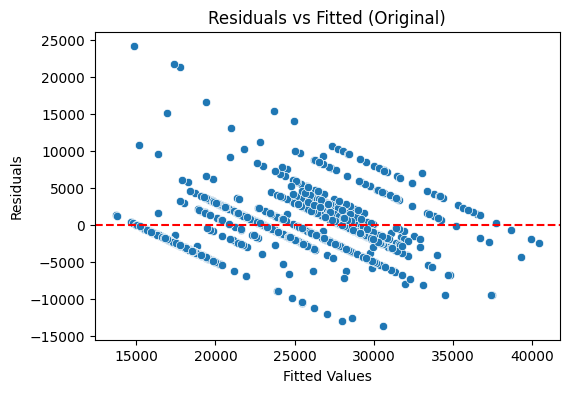

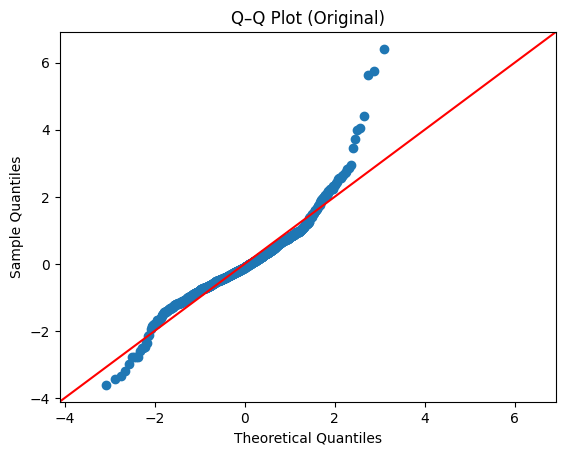


VIF (Original):
                    feature       VIF
0                    const  3.495599
1                      Age  1.319374
2                 Diabetes  1.077819
3    BloodPressureProblems  1.104843
4           AnyTransplants  1.004003
5       AnyChronicDiseases  1.020700
6           KnownAllergies  1.033943
7  HistoryOfCancerInFamily  1.079272
8   NumberOfMajorSurgeries  1.358480
9                      BMI  1.007909

Durbin–Watson: 1.9942
Shapiro–Wilk p-value: 1.7437e-20
Breusch–Pagan p-value: 5.8109e-17

After log-transform:
  Shapiro–Wilk p-value: 1.6444e-14
  Breusch–Pagan p-value: 2.3232e-18

Ridge CV R²: [0.6171988  0.52541596 0.66458473 0.67424385 0.73449961] mean: 0.6431885897060207
Huber CV R²: [0.61360182 0.50314627 0.64810566 0.66988906 0.73110395] mean: 0.633169353744689 

Final Linear Model (log-y) Performance:
  RMSE: 0.1500
  MAE : 0.1174
  R²  : 0.7166
Linear CV R² Scores: [0.61807224 0.52340029 0.66337123 0.67381111 0.73625187] mean: 0.6429813457227919 

Prediction

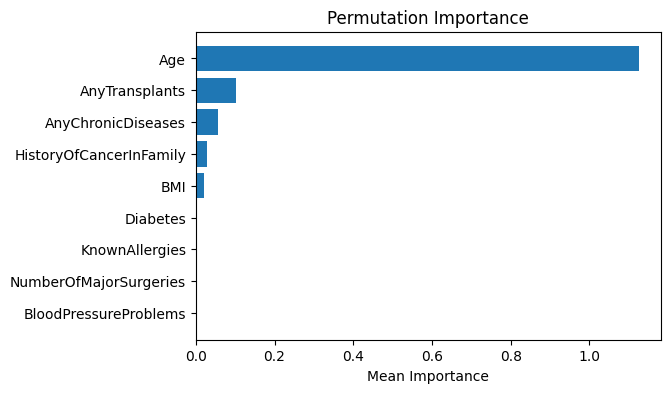

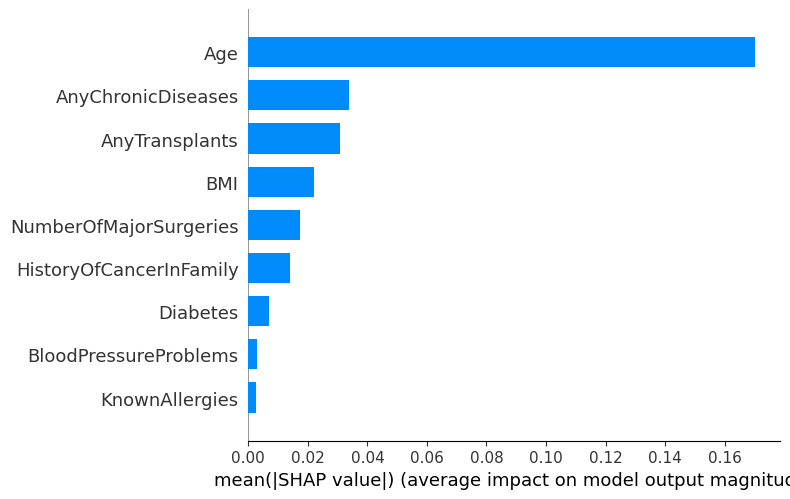

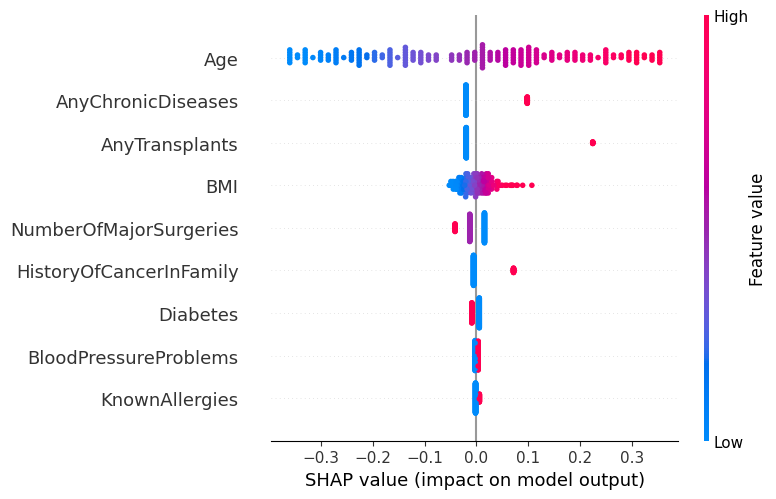

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import shap  

# 1. LOAD & FEATURE ENGINEERING
df = pd.read_csv(r'insurance.csv')
df['Height_m'] = df['Height'] / 100
df['BMI']      = df['Weight'] / (df['Height_m']**2)
df.drop(columns=['Height','Weight','Height_m'], inplace=True)

# 2. PREPARE X, y
X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']

# 3. SCALE NUMERICAL FEATURES
num_cols = ['Age','BMI','NumberOfMajorSurgeries']
scaler   = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4. ASSUMPTION DETECTION ON ORIGINAL MODEL
X_const = sm.add_constant(X)
ols_orig = sm.OLS(y, X_const).fit()
resid_orig = ols_orig.resid
fitted_orig = ols_orig.fittedvalues

# 4.1 Residuals vs Fitted
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted_orig, y=resid_orig)
plt.axhline(0, color='red', ls='--')
plt.title('Residuals vs Fitted (Original)')
plt.xlabel('Fitted Values'); plt.ylabel('Residuals')
plt.show()

# 4.2 Q-Q Plot
sm.qqplot(resid_orig, line='45', fit=True)
plt.title('Q–Q Plot (Original)')
plt.show()

# 4.3 VIF
vif = pd.DataFrame({
    'feature': X_const.columns,
    'VIF':     [variance_inflation_factor(X_const.values, i)
                for i in range(X_const.shape[1])]
})
print("\nVIF (Original):\n", vif)

# 4.4 Durbin–Watson
print(f"\nDurbin–Watson: {durbin_watson(resid_orig):.4f}")

# 4.5 Shapiro–Wilk
sw_stat, sw_p = shapiro(resid_orig)
print(f"Shapiro–Wilk p-value: {sw_p:.4e}")

# 4.6 Breusch–Pagan
bp = het_breuschpagan(resid_orig, X_const)
print(f"Breusch–Pagan p-value: {bp[1]:.4e}\n")

# 5. REMEDIES
# 5.1 Log-transform target
y_log = np.log(y)
ols_log = sm.OLS(y_log, X_const).fit()
resid_log = ols_log.resid

# Check again
sw_stat_log, sw_p_log = shapiro(resid_log)
bp_log = het_breuschpagan(resid_log, X_const)
print("After log-transform:")
print(f"  Shapiro–Wilk p-value: {sw_p_log:.4e}")
print(f"  Breusch–Pagan p-value: {bp_log[1]:.4e}\n")

# 5.2 RidgeCV (regularization)
ridge = RidgeCV(alphas=[0.1,1,10], cv=5)
ridge_cv_scores = cross_val_score(ridge, X, y_log,
                                  cv=KFold(5, shuffle=True, random_state=0),
                                  scoring='r2')
print("Ridge CV R²:", ridge_cv_scores, "mean:", ridge_cv_scores.mean())

# 5.3 HuberRegressor (robust)
huber = HuberRegressor()
huber_cv_scores = cross_val_score(huber, X, y_log,
                                  cv=KFold(5, shuffle=True, random_state=0),
                                  scoring='r2')
print("Huber CV R²:", huber_cv_scores, "mean:", huber_cv_scores.mean(), "\n")

# 6. FINAL LINEAR MODEL ON log(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 7. MODEL EVALUATION
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("Final Linear Model (log-y) Performance:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE : {mae:.4f}")
print(f"  R²  : {r2:.4f}")

# 8. CROSS-VALIDATION ON FINAL MODEL
cv_scores = cross_val_score(lr, X, y_log,
                            cv=KFold(5, shuffle=True, random_state=0),
                            scoring='r2')
print("Linear CV R² Scores:", cv_scores, "mean:", cv_scores.mean(), "\n")

# 9. CONFIDENCE & PREDICTION INTERVALS
pred_summary = ols_log.get_prediction(sm.add_constant(X_test))\
                      .summary_frame(alpha=0.05)
print("Prediction Intervals (first 5 rows):")
print(pred_summary[['mean','mean_ci_lower','mean_ci_upper',
                    'obs_ci_lower','obs_ci_upper']].head())

# 10. FEATURE IMPORTANCE
# 10.1 Permutation Importance
perm = permutation_importance(lr, X_test, y_test,
                              n_repeats=10, random_state=0)
perm_df = (pd.DataFrame({
    'feature': X.columns,
    'importance': perm.importances_mean
}).sort_values('importance', ascending=False))
print("\nPermutation Importance:\n", perm_df)

plt.figure(figsize=(6,4))
plt.barh(perm_df['feature'], perm_df['importance'])
plt.title('Permutation Importance')
plt.xlabel('Mean Importance')
plt.gca().invert_yaxis()
plt.show()

# 10.2 SHAP Explanations

# 1) Create an Independent masker over your training data
masker = shap.maskers.Independent(data=X_train)

# 2) Initialize the LinearExplainer with only the masker (no feature_perturbation)
explainer = shap.LinearExplainer(
    lr,
    masker
)

# 3) Compute SHAP values (using the new call API)
shap_explanation = explainer(X_test)

# 4) Plot global feature importance (bar chart)
shap.summary_plot(
    shap_explanation.values,
    X_test,
    plot_type="bar",
    feature_names=X.columns
)

# 5) Detailed beeswarm plot
shap.summary_plot(
    shap_explanation.values,
    X_test,
    feature_names=X.columns
)
